### Make paths to directories

In [77]:
import sys
import os

# Get the path to the current working directory
current_dir = os.getcwd()

# Get the path to the parent directory (containing both A.py and 'B' directory)
parent_dir = os.path.dirname(current_dir)

london_data_dir = os.path.join(parent_dir, 'Data/Flanders_dataset_big/preprocess')
results_dir = os.path.join(current_dir, 'resultsFlandersBig')
# Append the parent directory to the module search path
sys.path.append(parent_dir)
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator

### Imports

In [78]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator
from data_preprocessing.get_buffer_attributes import BufferAttributesCalculator

import numpy as np
import pandas as pd
import pickle
import datetime
import inspect
from pathlib import Path


### DATA generators

In [80]:
def get_meterids_with_NaNs(df):
    meterids_with_nans = set()
    for meterid, row in df.iterrows():
        if row.isna().any():
            meterids_with_nans.add(meterid)
    return meterids_with_nans



In [106]:
random_gen = np.random.default_rng(12341)

def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

def flanders_dataset(london_data_dir=london_data_dir, attributes = "flandersattributes.pkl", timeseries = "flanderstimeseries.pkl"):
    #return [], [], []

    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    attributes = attributes.drop(columns=['wdir','wspd','wpgt','pres'])

    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    return attributes, timeseries, folds

def flanders_dataset_with_buffer(buffer_attributes, london_data_dir = london_data_dir, attributes = "flandersattributes.pkl", timeseries = "flanderstimeseries.pkl", weekdays_only = True):
    #return [], [], []
    attributes_path = os.path.join(london_data_dir, attributes) #combined_attributes_filtered.pkl
    buffer_attributes_path = os.path.join(london_data_dir, buffer_attributes) #daily_data_df_filtered.pkl
    timeseries_path = os.path.join(london_data_dir, timeseries) #buffer_attributes_march_df.pkl
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    buffer_attributes = pd.read_pickle(buffer_attributes_path)
    merged_attributes = attributes.merge(buffer_attributes,on=['meterID'], how="left")
    
    merged_attributes = merged_attributes.drop(columns=['kurtosis_weekend','skewness_weekend', 'wdir','wspd','wpgt','pres'])
    to_drop = get_meterids_with_NaNs(merged_attributes)
    combined_attributes = merged_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(combined_attributes), dtype= 'int'), 5)

    return combined_attributes, timeseries, folds

In [82]:
def generate_dataset_with_2_buffer(buffer_attributes1, buffer_attributes2,start,end, london_data_dir = london_data_dir, attributes = "flandersattributes.pkl", timeseries = "flanderstimeseries.pkl"):    
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes) 
    buffer_attributes1_path = os.path.join(london_data_dir, buffer_attributes1)
    buffer_attributes2_path = os.path.join(london_data_dir, buffer_attributes2)
    timeseries_path = os.path.join(london_data_dir, timeseries) 
    
    timeseries = pd.read_pickle(timeseries_path)


    # Read data into DataFrames
    attributes = pd.read_pickle(attributes_path)
    buffer_attributes1 = pd.read_pickle(buffer_attributes1_path)
    buffer_attributes2 = pd.read_pickle(buffer_attributes2_path)
    
    # Add a new column to the original attributes DataFrame
    attributes['row_index'] = range(len(attributes))
    
    # Filter attributes DataFrame
    attributes1 = attributes[attributes['dayOfYear'].between(start,end)]
    attributes2 = attributes[~attributes['dayOfYear'].between(start,end)]
    
    # Merge DataFrames
    merged_attributes1 = attributes1.merge(buffer_attributes1, on=['meterID'], how="left")
    merged_attributes2 = attributes2.merge(buffer_attributes2, on=['meterID'], how="left")
    
    # Combine merged DataFrames
    combined_attributes = pd.concat([merged_attributes1, merged_attributes2])
    
    # Sort DataFrame based on the new column 'row_index'
    combined_attributes.sort_values(by='row_index', inplace=True)
    
    # Drop the 'row_index' column
    combined_attributes.drop(columns='row_index', inplace=True)
    combined_attributes = combined_attributes.drop(columns=['kurtosis_weekend','skewness_weekend','wdir','wspd','wpgt','pres'])
    
    to_drop = get_meterids_with_NaNs(combined_attributes)
    combined_attributes = combined_attributes.drop(index=to_drop)
    timeseries = timeseries.drop(index=to_drop)
    print(to_drop)
    folds = np.array_split(np.arange(0, len(combined_attributes), dtype= 'int'), 5)

    
    return combined_attributes, timeseries, folds, True, start, end



In [83]:
def generate_dataset_with_2_baseline(start,end, london_data_dir = london_data_dir, attributes = "flandersattributes.pkl", timeseries = "flanderstimeseries.pkl"):    
    return [], [], [], True, start, end

    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    attributes = attributes.drop(columns=['wdir','wspd','wpgt','pres'])

    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    
    return attributes, timeseries, folds, True, start, end


In [13]:
def get_NaNs(df):
    NaN_counts = df.isna().sum()
    for column_name, na_count in NaN_counts.items():
        if na_count > 0:
            print(f"Column {column_name} has {na_count} missing values.")
 

# Hyperparameter tuning

In [84]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlandersBig/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D6_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 100)),
        PCT_D8_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 100)),
        PCT_D10_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100)),
        PCT_D6_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 175)),
        PCT_D8_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 175)),
        PCT_D10_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 175)),
        PCT_D6_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 250)),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D10_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 350)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D12_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 350)),
        PCT_D10_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 650)),
        PCT_D10_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 850)),
        PCT_D10_M1000 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 1000)),


    )
    .add_datasets(
       
        flanders_dataset_baseline = flanders_dataset(),
        )
)

energy_scores, timing_df = experiment.execute()


Methods: 100%|██████████| 15/15 [00:01<00:00, 12.45it/s, method=PCT_D10_M1000]


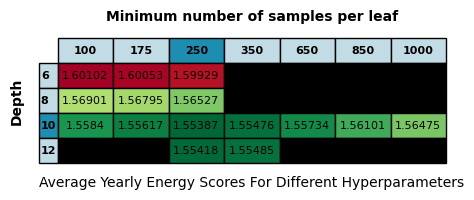

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(2.8, 2))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(-0.55, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('Pictures/tuningflandersbigbaseline.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlandersBig/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D6_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 100)),
        PCT_D8_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 100)),
        PCT_D10_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100)),
        PCT_D6_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 175)),
        PCT_D8_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 175)),
        PCT_D10_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 175)),
        PCT_D6_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 250)),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D10_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 350)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D12_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 350)),
        PCT_D10_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 650)),
        PCT_D10_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 850)),
        PCT_D10_M1000 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 1000)),


    )
    .add_datasets(
       
        #flanders_dataset_baseline = flanders_dataset(),
        Flanders_Jun_Dec = generate_dataset_with_2_buffer('buffer_attributes_month_6_all_df.pkl', 'buffer_attributes_month_12_all_df.pkl',61, 243),

        )
)

energy_scores, timing_df = experiment.execute()





Methods: 100%|██████████| 15/15 [00:01<00:00, 14.86it/s, method=PCT_D10_M1000]


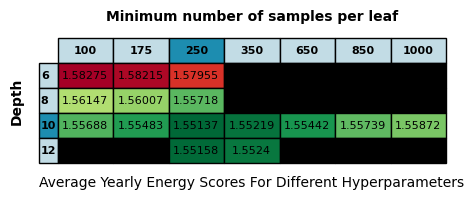

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(2.8, 2))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(-0.55, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('Pictures/tuningflandersbig.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


# Thesis experiment 1 buffer

In [91]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlandersBig/ThesisResults2buffer'), nb_of_samples = 250)
    .add_methods(
        Random_Baseline = RandomGenerator(),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        
    )
    .add_datasets(
        flanders_dataset_baseline = flanders_dataset(),
        )
)

energy_scores, timing_df = experiment.execute()

Methods: 100%|██████████| 2/2 [00:00<00:00,  6.96it/s, method=PCT_D10_M250]   


In [92]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlandersBig/ThesisResults2buffer'), nb_of_samples = 250)
    .add_methods(
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        
    )
    .add_datasets(
      
        flanders_dataset_with_buffer_jan = flanders_dataset_with_buffer('buffer_attributes_month_1_all_df.pkl'),
        flanders_dataset_with_buffer_feb = flanders_dataset_with_buffer('buffer_attributes_month_2_all_df.pkl'),
        flanders_dataset_with_buffer_mar = flanders_dataset_with_buffer('buffer_attributes_month_3_all_df.pkl'),
        flanders_dataset_with_buffer_apr = flanders_dataset_with_buffer('buffer_attributes_month_4_all_df.pkl'),
        flanders_dataset_with_buffer_may = flanders_dataset_with_buffer('buffer_attributes_month_5_all_df.pkl'),
        flanders_dataset_with_buffer_jun = flanders_dataset_with_buffer('buffer_attributes_month_6_all_df.pkl'),
        flanders_dataset_with_buffer_jul = flanders_dataset_with_buffer('buffer_attributes_month_7_all_df.pkl'),
        flanders_dataset_with_buffer_aug = flanders_dataset_with_buffer('buffer_attributes_month_8_all_df.pkl'),
        flanders_dataset_with_buffer_sep = flanders_dataset_with_buffer('buffer_attributes_month_9_all_df.pkl'),
        flanders_dataset_with_buffer_oct = flanders_dataset_with_buffer('buffer_attributes_month_10_all_df.pkl'),
        flanders_dataset_with_buffer_nov = flanders_dataset_with_buffer('buffer_attributes_month_11_all_df.pkl'),
        flanders_dataset_with_buffer_dec = flanders_dataset_with_buffer('buffer_attributes_month_12_all_df.pkl'),
        )
)

energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)

Methods: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s, method=PCT_D10_M250]


In [30]:
mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
display(sorted_es)

ES
PCT_D10_M250    flanders_dataset_with_buffer_aug  1.553980
                flanders_dataset_baseline         1.554141
                flanders_dataset_with_buffer_jul  1.554570
                flanders_dataset_with_buffer_sep  1.557494
                flanders_dataset_with_buffer_mar  1.558320
                flanders_dataset_with_buffer_jun  1.558795
                flanders_dataset_with_buffer_may  1.558943
                flanders_dataset_with_buffer_apr  1.559329
                flanders_dataset_with_buffer_oct  1.559925
                flanders_dataset_with_buffer_feb  1.563337
                flanders_dataset_with_buffer_jan  1.564709
                flanders_dataset_with_buffer_nov  1.565903
                flanders_dataset_with_buffer_dec  1.566000
Random_Baseline flanders_dataset_baseline         2.036702

In [93]:
# set the correct index to the energy scores
ldf = flanders_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='date', length=474500, freq=None)

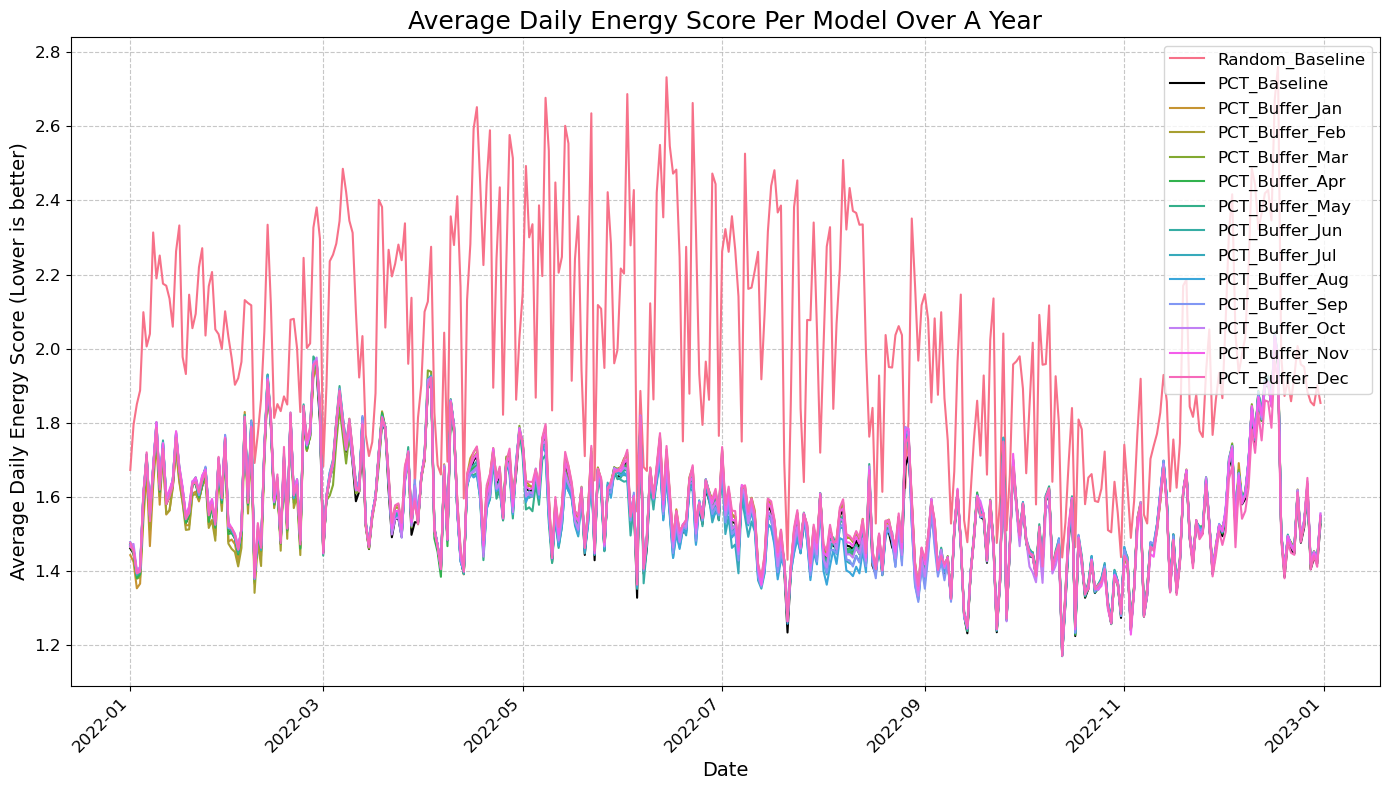

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'date' and calculate the mean and standard deviation for each day
df_avg = energy_scores.groupby('date').mean()
# df_std = energy_scores.groupby('date').std()

# Set a seaborn color palette
sns.set_palette("husl", len(df_avg.columns))

# Custom legend names
custom_legend_names = [
    'Random_Baseline',    
    'PCT_Baseline',       
    'PCT_Buffer_Jan',
    'PCT_Buffer_Feb',
    'PCT_Buffer_Mar',
    'PCT_Buffer_Apr',
    'PCT_Buffer_May',
    'PCT_Buffer_Jun',
    'PCT_Buffer_Jul',
    'PCT_Buffer_Aug',
    'PCT_Buffer_Sep',
    'PCT_Buffer_Oct',
    'PCT_Buffer_Nov',
    'PCT_Buffer_Dec'
]

# Plot the averages for all columns dynamically with different colors
plt.figure(figsize=(14, 8))

# Iterate over all columns and plot them with different colors
for i, column in enumerate(df_avg.columns):
    color = sns.color_palette()[i]  # Use seaborn color palette
    if i == 1:
        color = 'black'
    plt.plot(df_avg.index, df_avg[column], linestyle='-', color=color, label=custom_legend_names[i])

# Set plot aesthetics
plt.title('Average Daily Energy Score Per Model Over A Year', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Daily Energy Score (Lower is better)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('pictures/flandersbigyeargraph.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [34]:
for i in range(1,13):
    technique_A = df_avg.iloc[:, 1]
    technique_B = df_avg.iloc[:, i]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  0.0
lower in A:  19.726027397260275
lower in A:  19.17808219178082
lower in A:  36.986301369863014
lower in A:  30.684931506849317
lower in A:  28.493150684931507
lower in A:  27.945205479452056
lower in A:  31.232876712328768
lower in A:  30.136986301369863
lower in A:  32.87671232876712
lower in A:  31.780821917808222
lower in A:  9.863013698630137


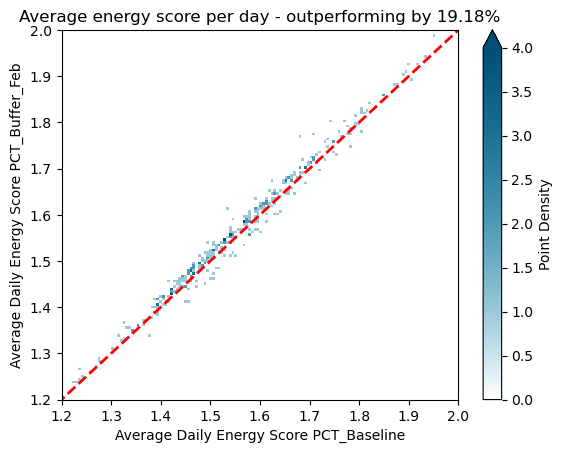

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 1]
technique_B = df_avg.iloc[:, 3]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Feb')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(1.2, 2)
plt.ylim(1.2, 2)
# Show the plot
plt.savefig('pictures/flandersbigdailycomparison.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

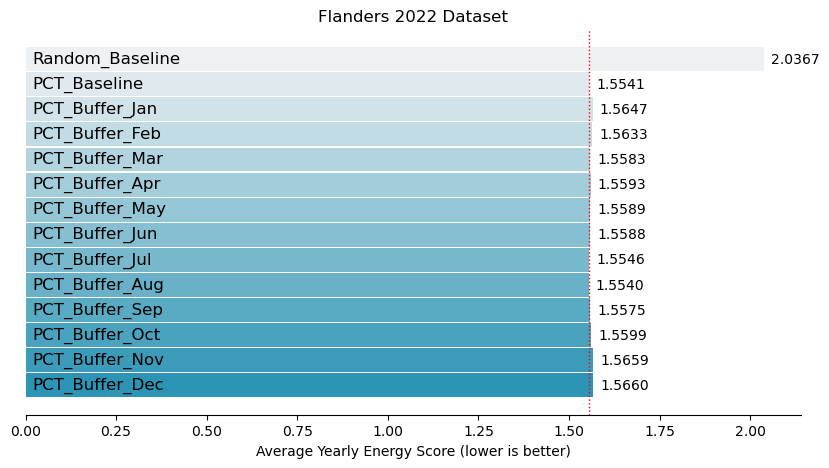

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
extended_list = [f'PCT_Buffer_{month}' for month in months]
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques.extend(extended_list)

# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('Flanders 2022 Dataset')
plt.savefig('pictures/energy_score_comparison_flandersbig.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()


In [98]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
energy_scores = energy_scores.drop(energy_scores.columns[0], axis=1)
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')

# Rename the index for clarity
monthly_means.index = ['PCT_Baseline', 'PCT_Buffer_Jan', 'PCT_Buffer_Feb', 'PCT_Buffer_Mar', 'PCT_Buffer_Apr', 'PCT_Buffer_May', 'PCT_Buffer_Jun', 'PCT_Buffer_Jul', 'PCT_Buffer_Aug', 'PCT_Buffer_Sep', 'PCT_Buffer_Oct', 'PCT_Buffer_Nov', 'PCT_Buffer_Dec']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,1.598371,1.651776,1.633889,1.633751,1.603905,1.576312,1.497887,1.484974,1.461098,1.406498,1.477501,1.630989
PCT_Buffer_Jan,1.574503,1.650909,1.652161,1.648534,1.621100,1.596081,1.518336,1.507818,1.472066,1.414038,1.482567,1.644812
PCT_Buffer_Feb,1.580340,1.635330,1.650463,1.646472,1.619125,1.595048,1.515222,1.507827,1.472095,1.413866,1.482984,1.646412
PCT_Buffer_Mar,1.602054,1.652134,1.633046,1.633562,1.603426,1.582156,1.498882,1.489540,1.469624,1.415012,1.482268,1.645101
PCT_Buffer_Apr,1.600190,1.658607,1.647942,1.626935,1.604821,1.583770,1.498723,1.490447,1.469195,1.410341,1.486291,1.642002
PCT_Buffer_May,1.610593,1.665257,1.650525,1.624293,1.584040,1.577214,1.493132,1.489169,1.471207,1.418362,1.485010,1.646285
PCT_Buffer_Jun,1.611803,1.664890,1.651663,1.635349,1.595584,1.563439,1.495070,1.487031,1.466785,1.413172,1.483403,1.644836
PCT_Buffer_Jul,1.608864,1.662767,1.650718,1.631338,1.592866,1.565938,1.469715,1.473785,1.466543,1.415365,1.480810,1.644221
PCT_Buffer_Aug,1.610196,1.662464,1.648227,1.627037,1.593018,1.568961,1.477268,1.459233,1.465554,1.414288,1.485269,1.644517
PCT_Buffer_Sep,1.611109,1.665087,1.654734,1.631695,1.599683,1.577511,1.488730,1.471355,1.458055,1.411394,1.484855,1.643616


In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for v in x:
        style = color_gradient(v, min(x), max(x), base_val)
        if v < base_val:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_Baseline Comparison</b>"))

# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,1.59837,1.65178,1.63389,1.63375,1.60391,1.57631,1.49789,1.48497,1.46110,1.40650,1.47750,1.63099
PCT_Buffer_Jan,1.57450,1.65091,1.65216,1.64853,1.62110,1.59608,1.51834,1.50782,1.47207,1.41404,1.48257,1.64481
PCT_Buffer_Feb,1.58034,1.63533,1.65046,1.64647,1.61913,1.59505,1.51522,1.50783,1.47209,1.41387,1.48298,1.64641
PCT_Buffer_Mar,1.60205,1.65213,1.63305,1.63356,1.60343,1.58216,1.49888,1.48954,1.46962,1.41501,1.48227,1.64510
PCT_Buffer_Apr,1.60019,1.65861,1.64794,1.62694,1.60482,1.58377,1.49872,1.49045,1.46919,1.41034,1.48629,1.64200
PCT_Buffer_May,1.61059,1.66526,1.65053,1.62429,1.58404,1.57721,1.49313,1.48917,1.47121,1.41836,1.48501,1.64629
PCT_Buffer_Jun,1.61180,1.66489,1.65166,1.63535,1.59558,1.56344,1.49507,1.48703,1.46678,1.41317,1.48340,1.64484
PCT_Buffer_Jul,1.60886,1.66277,1.65072,1.63134,1.59287,1.56594,1.46972,1.47379,1.46654,1.41537,1.48081,1.64422
PCT_Buffer_Aug,1.61020,1.66246,1.64823,1.62704,1.59302,1.56896,1.47727,1.45923,1.46555,1.41429,1.48527,1.64452
PCT_Buffer_Sep,1.61111,1.66509,1.65473,1.63169,1.59968,1.57751,1.48873,1.47135,1.45805,1.41139,1.48486,1.64362


# Thesis experiment 2 buffers


In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlandersBig/ThesisResults2buffer'), nb_of_samples = 250)
    .add_methods(
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
       
    )
    .add_datasets(
    
        Flanders_Jan_Jul_baseline = generate_dataset_with_2_baseline(91,273),
        Flanders_Feb_Aug_baseline = generate_dataset_with_2_baseline(122,304),
        Flanders_Mar_Sep_baseline = generate_dataset_with_2_baseline(153, 335),
        Flanders_Apr_Okt_baseline = generate_dataset_with_2_baseline(183, 365),
        Flanders_May_Nov_baseline = generate_dataset_with_2_baseline(30,212),
        Flanders_Jun_Dec_baseline = generate_dataset_with_2_baseline(61, 243),
        Flanders_Jan_Jul = generate_dataset_with_2_buffer('buffer_attributes_month_7_all_df.pkl', 'buffer_attributes_month_1_all_df.pkl',91,273),
        Flanders_Feb_Aug = generate_dataset_with_2_buffer('buffer_attributes_month_8_all_df.pkl', 'buffer_attributes_month_2_all_df.pkl',122,304),
        Flanders_Mar_Sep = generate_dataset_with_2_buffer('buffer_attributes_month_9_all_df.pkl', 'buffer_attributes_month_3_all_df.pkl', 153, 335),
        Flanders_Apr_Okt = generate_dataset_with_2_buffer('buffer_attributes_month_10_all_df.pkl', 'buffer_attributes_month_4_all_df.pkl', 183, 365),
        Flanders_May_Nov = generate_dataset_with_2_buffer('buffer_attributes_month_5_all_df.pkl', 'buffer_attributes_month_11_all_df.pkl',30,212),
        Flanders_Jun_Dec = generate_dataset_with_2_buffer('buffer_attributes_month_6_all_df.pkl', 'buffer_attributes_month_12_all_df.pkl',61, 243),
        )
)

energy_scores, timing_df = experiment.execute()

Methods: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, method=PCT_D10_M250]


In [101]:
# set the correct index to the energy scores
ldf = flanders_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='date', length=474500, freq=None)

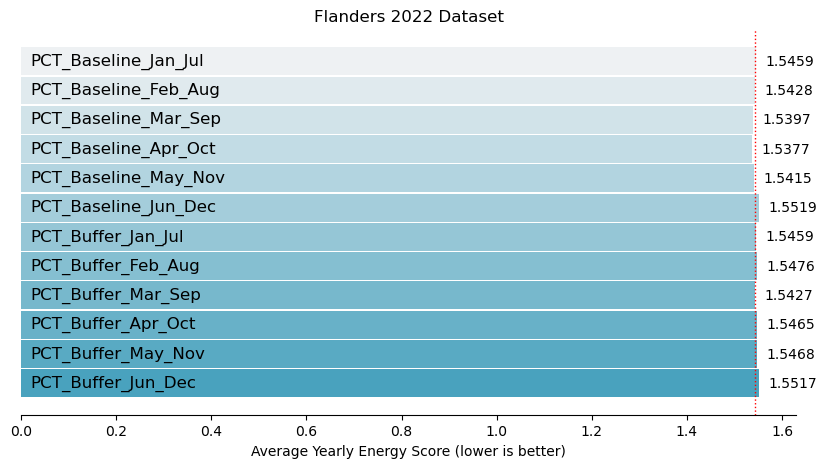

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('Flanders 2022 Dataset')
plt.savefig('pictures/energy_score_comparison_flandersbig_2buffers.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()

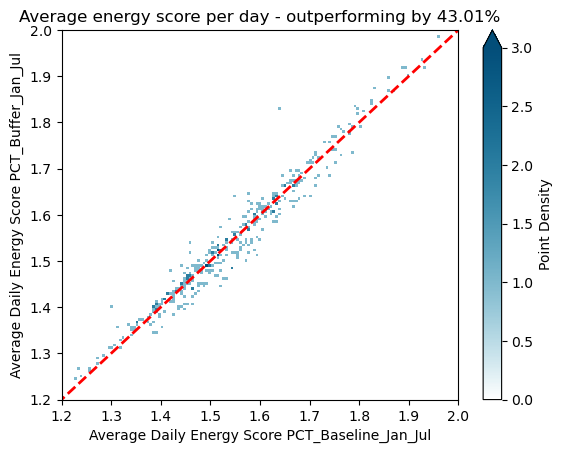

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 0]
technique_B = df_avg.iloc[:, 6]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline_Jan_Jul')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Jan_Jul')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(1.2, 2)
plt.ylim(1.2, 2)
# Show the plot
plt.savefig('pictures/flandersbigdailycomparison2buffers.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [104]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')
techniques = [f'PCT_Baseline_{months[i]}_{months[i+6]}' for i in range(6)]
techniques.extend([f'PCT_Buffer_{months[i]}_{months[i+6]}' for i in range(6)])
# Rename the index for clarity
monthly_means.index = techniques#['PCT January', 'PCT February', 'PCT March', 'PCT April', 'PCT May', 'PCT June', 'PCT July', 'PCT August', 'PCT September', 'PCT October', 'PCT November', 'PCT December']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,1.595334,1.642610,1.601075,1.633624,1.597282,1.561170,1.492839,1.462583,1.466805,1.408292,1.471139,1.626306
PCT_Baseline_Feb_Aug,1.596248,1.639177,1.604880,1.613047,1.599015,1.559157,1.481179,1.468218,1.454387,1.407552,1.473968,1.623676
PCT_Baseline_Mar_Sep,1.593882,1.642616,1.601645,1.611523,1.590469,1.544830,1.472612,1.460898,1.456950,1.412202,1.470574,1.626304
PCT_Baseline_Apr_Oct,1.597143,1.619628,1.608736,1.617032,1.593857,1.561934,1.466701,1.454611,1.445906,1.398697,1.475210,1.618786
PCT_Baseline_May_Nov,1.591701,1.619119,1.607109,1.626972,1.599506,1.559572,1.485418,1.452571,1.456809,1.409271,1.472083,1.623719
PCT_Baseline_Jun_Dec,1.591210,1.645040,1.619322,1.627955,1.606573,1.574351,1.503811,1.493627,1.460647,1.400540,1.483810,1.622484
PCT_Buffer_Jan_Jul,1.567664,1.643908,1.610450,1.650859,1.593711,1.548516,1.466856,1.449958,1.487637,1.422274,1.478158,1.639860
PCT_Buffer_Feb_Aug,1.582407,1.630494,1.615883,1.633944,1.609518,1.564970,1.476349,1.454008,1.464707,1.421986,1.480001,1.643596
PCT_Buffer_Mar_Sep,1.599700,1.649786,1.596498,1.617076,1.598505,1.549216,1.466485,1.450090,1.451673,1.419389,1.480226,1.641497
PCT_Buffer_Apr_Oct,1.609189,1.629806,1.621388,1.615238,1.601574,1.578598,1.482334,1.462983,1.452368,1.395425,1.480265,1.635352


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for i, v in enumerate(x):
        style = color_gradient(v, min(x), max(x), base_val)
        if i >= 6 and v < x[i - 6]:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_2Baselines Comparison</b>"))


# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline_Jan_Jul,1.59533,1.64261,1.60108,1.63362,1.59728,1.56117,1.49284,1.46258,1.46680,1.40829,1.47114,1.62631
PCT_Baseline_Feb_Aug,1.59625,1.63918,1.60488,1.61305,1.59901,1.55916,1.48118,1.46822,1.45439,1.40755,1.47397,1.62368
PCT_Baseline_Mar_Sep,1.59388,1.64262,1.60165,1.61152,1.59047,1.54483,1.47261,1.46090,1.45695,1.41220,1.47057,1.62630
PCT_Baseline_Apr_Oct,1.59714,1.61963,1.60874,1.61703,1.59386,1.56193,1.46670,1.45461,1.44591,1.39870,1.47521,1.61879
PCT_Baseline_May_Nov,1.59170,1.61912,1.60711,1.62697,1.59951,1.55957,1.48542,1.45257,1.45681,1.40927,1.47208,1.62372
PCT_Baseline_Jun_Dec,1.59121,1.64504,1.61932,1.62796,1.60657,1.57435,1.50381,1.49363,1.46065,1.40054,1.48381,1.62248
PCT_Buffer_Jan_Jul,1.56766,1.64391,1.61045,1.65086,1.59371,1.54852,1.46686,1.44996,1.48764,1.42227,1.47816,1.63986
PCT_Buffer_Feb_Aug,1.58241,1.63049,1.61588,1.63394,1.60952,1.56497,1.47635,1.45401,1.46471,1.42199,1.48000,1.64360
PCT_Buffer_Mar_Sep,1.59970,1.64979,1.59650,1.61708,1.59850,1.54922,1.46649,1.45009,1.45167,1.41939,1.48023,1.64150
PCT_Buffer_Apr_Oct,1.60919,1.62981,1.62139,1.61524,1.60157,1.57860,1.48233,1.46298,1.45237,1.39543,1.48027,1.63535
